# Initialization

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping

from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import DataLoaders, inplace
from miniai.conv import conv

/scratch/users/carles/mambaforge/envs/mini-diffusers/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from fastcore.test import test_close
from miniai.utils import set_seed, def_device

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [3]:
xl, yl = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)

@inplace
def transformi(b):
    b[xl] = [TF.to_tensor(o) for o in b[xl]]
    
bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=10)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [4]:
from miniai.learner import MomentumLearner, DeviceCB, MetricsCB, ProgressCB
from miniai.activations import ActivationStats
from miniai.utils import clean_ipython_hist, clean_tb, clean_mem

In [5]:
def get_model(): 
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64), conv(64,10, act=False), nn.Flatten()).to(def_device)

In [6]:
#MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [7]:
metrics = MetricsCB(accuracy=MulticlassAccuracy()) 
astats = ActivationStats(fc.risinstance(nn.ReLU)) 
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats] 
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.280,2.130,0,train
0.421,1.545,0,eval


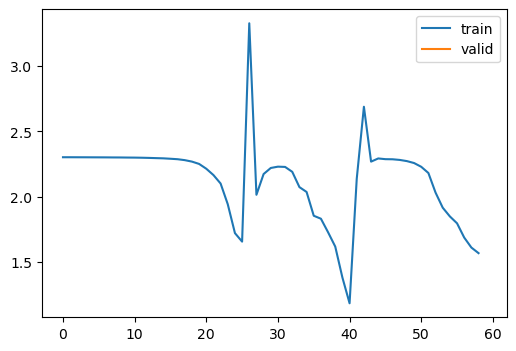

In [8]:
learn.fit(1)

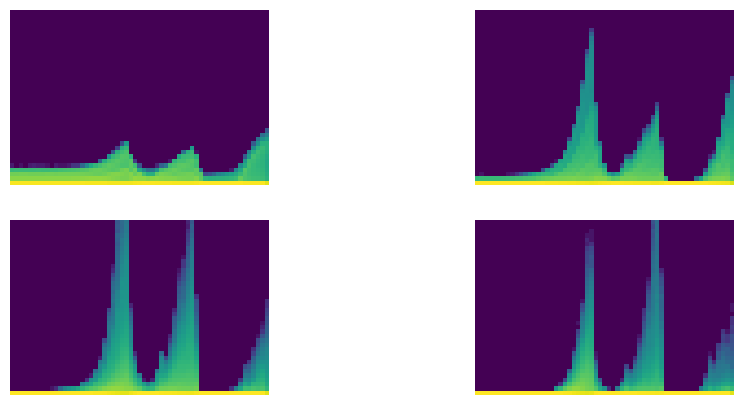

In [9]:
astats.color_dim()

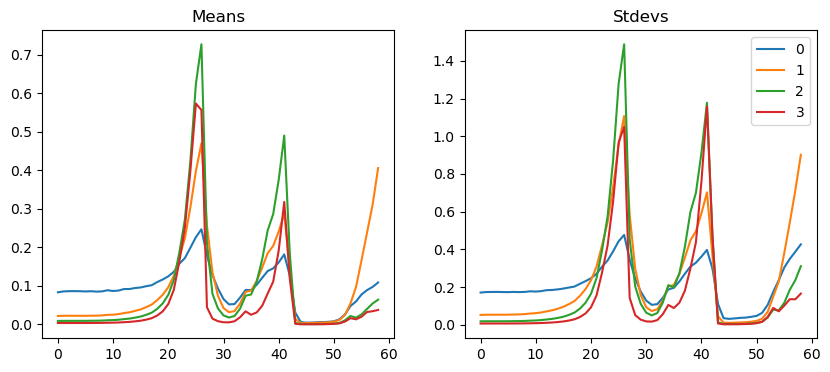

In [10]:
astats.plot_stats()

# Glorot/Xavier init

In [12]:
x = torch.randn(200, 100)
for i in range(50):
    x = x @ torch.randn(100,100)
x[0:5, 0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

# Applying an init function

In [14]:
model = get_model()
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [15]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        init.kaiming_normal_(m.weight)

In [17]:
model.apply(init_weights);

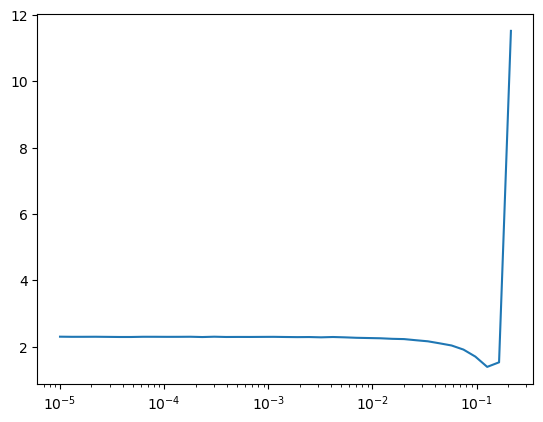

In [18]:
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

accuracy,loss,epoch,train
0.625,1.085,0,train
0.803,0.542,0,eval
0.841,0.441,1,train
0.841,0.436,1,eval
0.861,0.382,2,train
0.861,0.382,2,eval


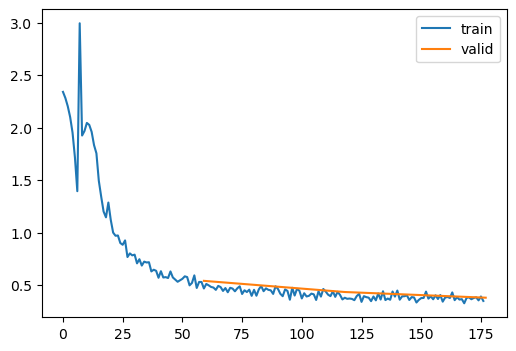

In [19]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

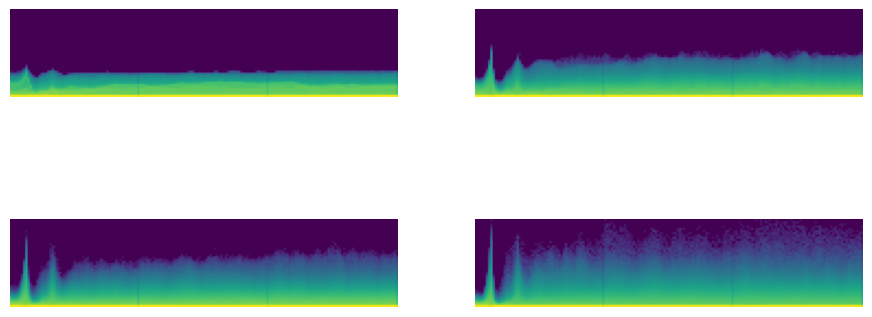

In [20]:
astats.color_dim()

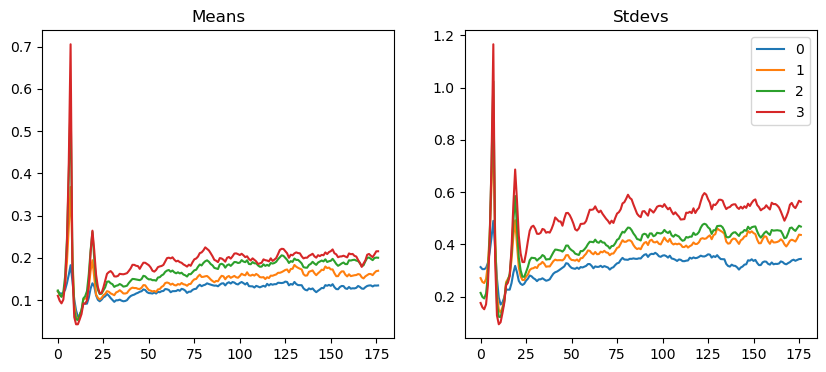

In [21]:
astats.plot_stats()

# General ReLU

In [32]:
from miniai.init import GeneralRelu, get_model, init_weights

In [33]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

accuracy,loss,epoch,train
0.739,0.753,0,train
0.832,0.464,0,eval
0.856,0.389,1,train
0.855,0.387,1,eval
0.874,0.341,2,train
0.869,0.353,2,eval


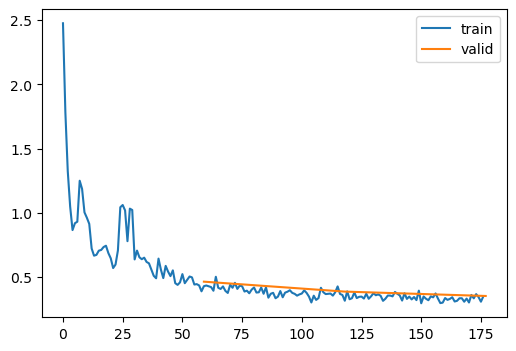

In [34]:
set_seed(42)
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

# BatchNorm

accuracy,loss,epoch,train
0.833,0.460,0,train
0.856,0.403,0,eval
0.880,0.323,1,train
0.858,0.381,1,eval
0.894,0.284,2,train
0.883,0.310,2,eval


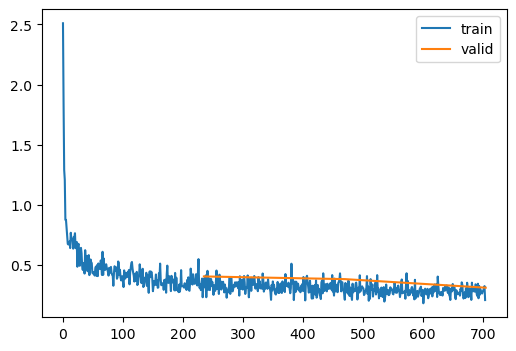

In [35]:
dls = DataLoaders.from_dd(tds, 256, num_workers=4)
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.917,0.225,0,train
0.898,0.280,0,eval
0.922,0.212,1,train
0.905,0.274,1,eval


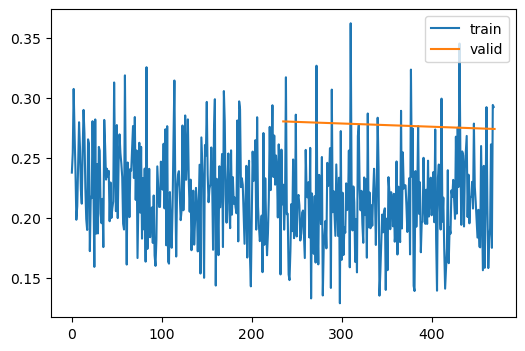

In [36]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)